In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *
from sklearn.linear_model import LogisticRegression # Logistic Regression Model
from sklearn.linear_model import LinearRegression # Logistic Regression Model
from sklearn.metrics import mean_squared_error, r2_score #model evaluation

from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.neighbors import KNeighborsClassifier

from sklearn.cluster import KMeans # k-means
from sklearn.mixture import GaussianMixture # EM/GMM
from sklearn.cluster import AgglomerativeClustering # hierarchical agglomerative clustering
from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix


%matplotlib inline

In [3]:
health = pd.read_csv("michael_data.csv")
days = [i for i in range(1,len(health)+1)]
health["Days"] = days
cols = health.columns.tolist()
for i in cols:
    col = health[i].tolist()
    col.reverse()
    health[i] = col

#Statistics for my weekends
weekend = ["Fri", "Sat", "Sun" ]
weekendData = ["Week Day"] * len(health)
for i in range(len(health)):
    if (health["Unnamed: 1"][i] in weekend):
        weekendData[i] = "Weekend"
health["Days of the Week"] = weekendData
health.head()
# cols = health.columns[0:4]
# health = health.iloc[::-1]
# health1 = health[cols]
# health1
# health = health.sort_index(ascending=True, axis=0)
# health.head()
# health1 = health.reindex(index=health.index[::-1])
# cols = health.columns[0:4]
# health.head()


,Date,Unnamed: 1,Stress Level,Hrs,Resting Heart Rate,Max Heart Rate,Active Calories,Total Steps,Days,Days of the Week
0,2-Dec,Wed,27,6.7,45,159,760,6286,148,Week Day
1,1-Dec,Tue,26,8.1,45,150,968,6730,147,Week Day
2,30-Nov,Mon,15,8.0,43,128,355,5813,146,Week Day
3,29-Nov,Sun,23,7.7,44,131,497,8128,145,Weekend
4,28-Nov,Sat,26,8.7,48,175,1189,17396,144,Weekend


In [5]:
def change_date(dates):
    month_dict = {"01": "Jan", "02": "Feb", "03": "Mar", "04": "Apr", "05": "May", "06": "Jun", "07": "Jul", "08": "Aug", "09": "Sep", "10": "Oct", "11": "Nov", "12": "Dec"}
    new_dates = []
    for row in dates:
        date_str = row.split()[0]
        month = month_dict[date_str.split("-")[1]]
        day = date_str.split("-")[2]
        if int(day) < 10:
            day = day[1]
        new_dates.append(day + "-" +  month)
    return new_dates
activities = pd.read_csv("michael_new_activities.csv")

activities.head()

,Activity Type,Date,Favorite,Title,Distance,Calories,Time,Avg HR,Max HR,Aerobic TE,...,Best Lap Time,Number of Laps,Max Temp,Avg Resp,Min Resp,Max Resp,Stress Change,Stress Start,Stress End,Avg Stress
0,Cycling,2020-12-06,False,San Jose Cycling,25.35,890,1:49:24,123,166,2.8,...,03:15.0,6,0,16,16,16,--,--,--,--
1,Cycling,2020-12-05,False,San Jose Cycling,33.46,"1,303",2:00:28,138,178,3.4,...,12:30.1,7,0,17,17,17,--,--,--,--
2,Strength Training,2020-12-04,False,Strength,0.00,252,0:32:57,113,139,1.2,...,32:57.3,1,0,18,18,18,--,--,--,--
3,Cycling,2020-12-04,False,San Jose Cycling,11.80,639,0:51:33,140,178,3.1,...,07:35.9,3,0,16,16,16,--,--,--,--
4,Cycling,2020-12-03,False,San Jose Cycling,20.51,906,1:17:08,140,179,3.1,...,02:08.1,5,0,16,16,16,--,--,--,--


In [198]:
activities = pd.read_csv("michael_new_activities.csv")
activities["Date"] = change_date(activities["Date"])
activities.head()

,Activity Type,Date,Favorite,Title,Distance,Calories,Time,Avg HR,Max HR,Aerobic TE,...,Best Lap Time,Number of Laps,Max Temp,Avg Resp,Min Resp,Max Resp,Stress Change,Stress Start,Stress End,Avg Stress
0,Cycling,6-Dec,False,San Jose Cycling,25.35,890,1:49:24,123,166,2.8,...,03:15.0,6,0,16,16,16,--,--,--,--
1,Cycling,5-Dec,False,San Jose Cycling,33.46,"1,303",2:00:28,138,178,3.4,...,12:30.1,7,0,17,17,17,--,--,--,--
2,Strength Training,4-Dec,False,Strength,0.00,252,0:32:57,113,139,1.2,...,32:57.3,1,0,18,18,18,--,--,--,--
3,Cycling,4-Dec,False,San Jose Cycling,11.80,639,0:51:33,140,178,3.1,...,07:35.9,3,0,16,16,16,--,--,--,--
4,Cycling,3-Dec,False,San Jose Cycling,20.51,906,1:17:08,140,179,3.1,...,02:08.1,5,0,16,16,16,--,--,--,--


# Make a function that calculates exercise calories per day and see if its the same as existing active calories

In [199]:
def exercise_per_day(df_health, df_activities):
    date_health = df_health["Date"].tolist()
    date_exercise = df_activities["Date"].tolist()
    df_combined = df_health
    exercise = [0] * len(date_health)
    for i in range(len(date_health)): #len(date_health)):
        if date_health[i] in date_exercise:
            exercise[i] = 1
    df_combined["Exercise"] = exercise
    return df_combined

#     count = 0
#     mylist = list(dict.fromkeys(date_exercise))

#     for i in exercise:
#         if i:
#             pass
# #             print(date_exercise)
#     print(count)
#     mylist = list(set(date_exercise))
#     print(len(mylist))
#     print(len(df_activities))
#     for i in range(len(date_exercise) - 1):
#         if date_exercise[i] == date_exercise[i + 1]:
#             count += 1
#             print(date_exercise[i])
#     print(count)
#     return exercise
#     i = 0
#     j = 0
#     exercise = []
#     while i < len(df_health) and j < df_activities(len):
#         if (date_health[i] == date_exercise[])
df_combined = exercise_per_day(health, activities)
print(len(df_combined))

df_combined = df_combined.loc[df_combined["Hrs"] != 0]
df_combined = df_combined.loc[df_combined["Stress Level"] > 14]
# df_combined = df_combined.loc[df_combined["Resting Heart Rate"] <= 50]
# df_combined = df_combined.loc[df_combined["Resting Heart Rate"] <= 50]

print(len(df_combined))

# df_combined.loc[1:10]

# x = df_combined["Stress Level"] < 15
# x = df_combined["Hrs"] == 0

# df_combined.loc[x]
df_combined["Exercise"].tolist().count(1)
df_combined["Exercise"].tolist().count(1)
df_combined.head(30)


148
119


,Date,Unnamed: 1,Stress Level,Hrs,Resting Heart Rate,Max Heart Rate,Active Calories,Total Steps,Days,Days of the Week,Exercise
0,2-Dec,Wed,27,6.7,45,159,760,6286,148,Week Day,1
1,1-Dec,Tue,26,8.1,45,150,968,6730,147,Week Day,1
2,30-Nov,Mon,15,8.0,43,128,355,5813,146,Week Day,1
3,29-Nov,Sun,23,7.7,44,131,497,8128,145,Weekend,1
4,28-Nov,Sat,26,8.7,48,175,1189,17396,144,Weekend,1
5,27-Nov,Fri,27,9.2,45,121,463,12451,143,Weekend,0
6,26-Nov,Thu,26,9.1,47,115,388,7272,142,Week Day,1
7,25-Nov,Wed,18,8.0,43,123,554,11279,141,Week Day,1
8,24-Nov,Tue,19,7.9,45,147,642,10904,140,Week Day,1
9,23-Nov,Mon,26,7.9,43,144,680,12447,139,Week Day,1


In [215]:
activities.iloc[::-1].head(30)

,Activity Type,Date,Favorite,Title,Distance,Calories,Time,Avg HR,Max HR,Aerobic TE,...,Best Lap Time,Number of Laps,Max Temp,Avg Resp,Min Resp,Max Resp,Stress Change,Stress Start,Stress End,Avg Stress
190,Cycling,7-Jul,False,San Jose Cycling,9.74,362,0:39:59,121,149,1.9,...,16:50.7,2,0,--,--,--,--,--,--,--
189,Hiking,8-Jul,False,Santa Clara County Hiking,2.63,389,1:12:17,94,127,0.5,...,12:16.6,1,0,17,17,17,--,--,--,--
188,Strength Training,8-Jul,False,Strength,0.00,281,0:33:05,121,148,1.8,...,33:04.9,1,0,18,18,18,--,--,--,--
187,Running,8-Jul,False,San Jose Running,2.84,351,0:26:49,143,163,2.3,...,00:44.0,4,0,25,16,37,--,--,--,--
186,Cycling,8-Jul,False,San Jose Cycling,10.23,324,0:47:49,109,151,1.1,...,01:04.5,3,0,14,14,14,--,--,--,--
185,Strength Training,9-Jul,False,Strength,0.00,409,1:02:03,114,138,1.7,...,02:02.6,1,0,18,18,18,--,--,--,--
184,Running,9-Jul,False,San Jose Running,3.16,445,0:36:08,143,186,2.8,...,02:46.6,4,0,17,17,17,--,--,--,--
183,Strength Training,10-Jul,False,Strength,0.00,364,0:58:06,110,136,1.2,...,58:05.9,1,0,17,17,17,--,--,--,--
182,Running,10-Jul,False,San Jose Running,0.45,77,06:42.7,127,146,1.0,...,06:42.8,1,0,16,16,16,--,--,--,--
181,Strength Training,10-Jul,False,Strength,0.00,405,0:48:14,120,170,2.6,...,48:13.7,1,0,21,21,21,--,--,--,--


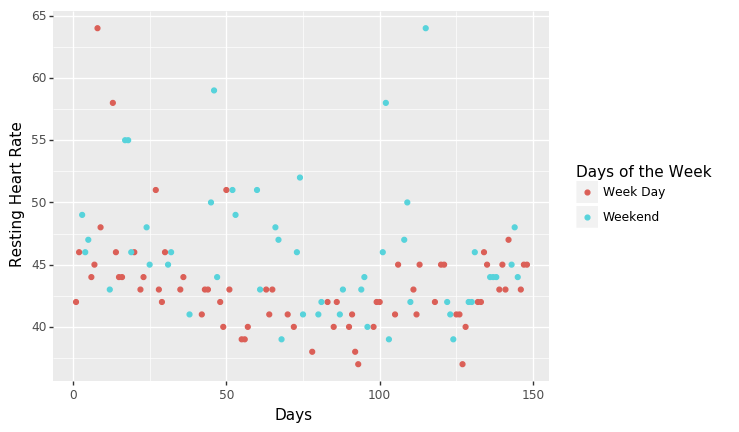

<ggplot: (8743958767945)>

In [139]:
(ggplot(df_combined, aes(x = "Days", y = "Resting Heart Rate", color = "Days of the Week")) + geom_point())

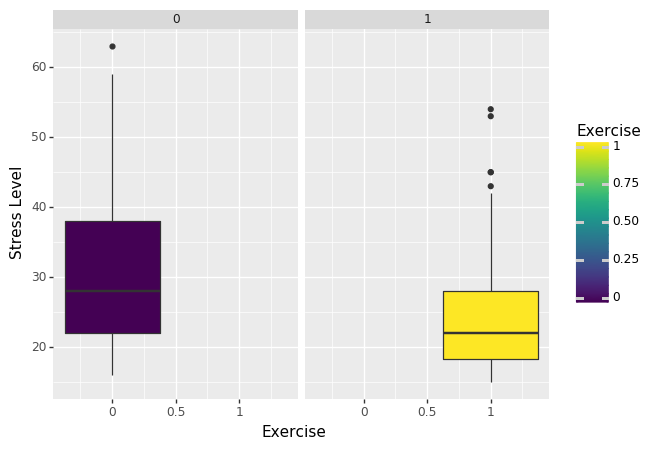

<ggplot: (8743958538573)>

In [203]:

(ggplot(df_combined, aes(x = "Exercise", y = "Stress Level", fill = "Exercise")) + geom_boxplot() + facet_wrap("~Exercise"))

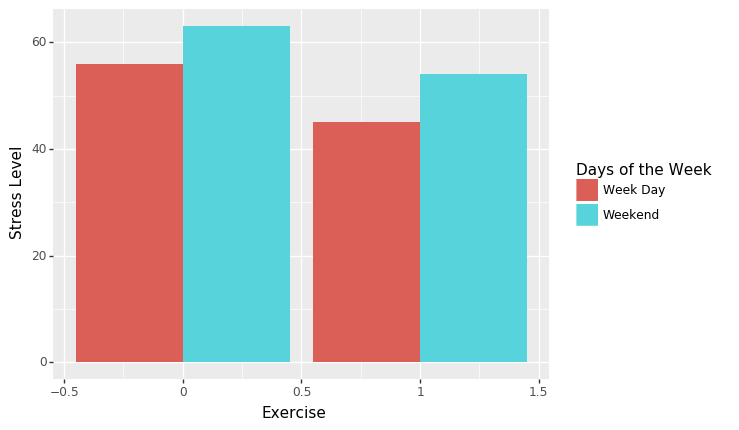

<ggplot: (8743958753521)>

In [212]:
(ggplot(df_combined, aes(x = "Exercise", y = "Stress Level", fill = "Days of the Week")) + geom_bar(stat = 'identity', position = 'dodge'))

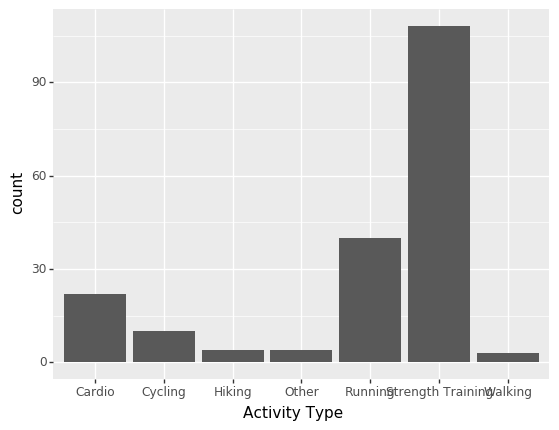

<ggplot: (8743958732161)>

In [216]:
# The distribution of the types of my workouts
(ggplot(activities, aes(x = "Activity Type")) + geom_bar())

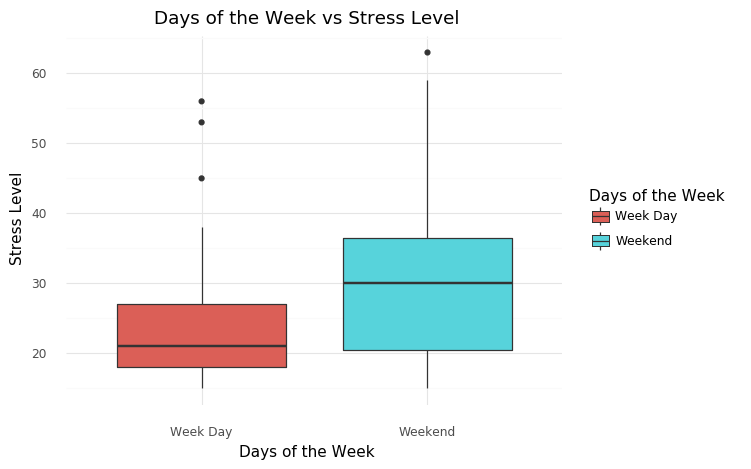

<ggplot: (8743958315733)>

In [141]:
(ggplot(df_combined, aes(x = "Days of the Week", y = "Stress Level", fill = "Days of the Week")) + 
 ggtitle("Days of the Week vs Stress Level") + 
 theme_minimal() +
 geom_boxplot())

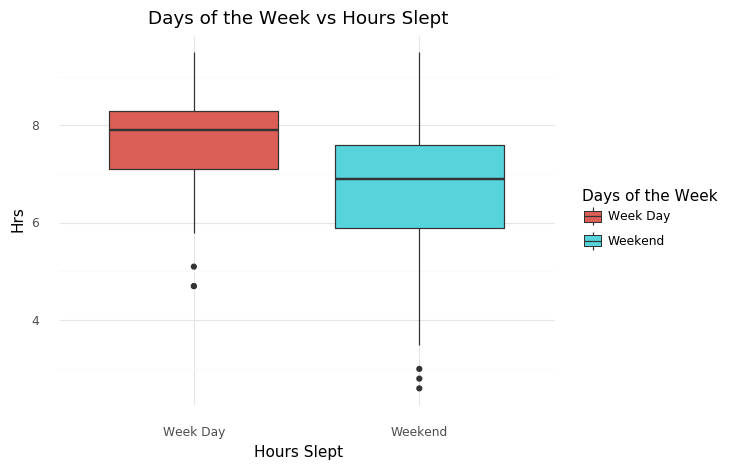

<ggplot: (8743958783541)>

In [142]:
(ggplot(df_combined, aes(x = "Days of the Week", y = "Hrs", fill = "Days of the Week")) + 
 ggtitle("Days of the Week vs Hours Slept") + 
 labs(x = "Hours Slept") +
 theme_minimal() +
 
 geom_boxplot())

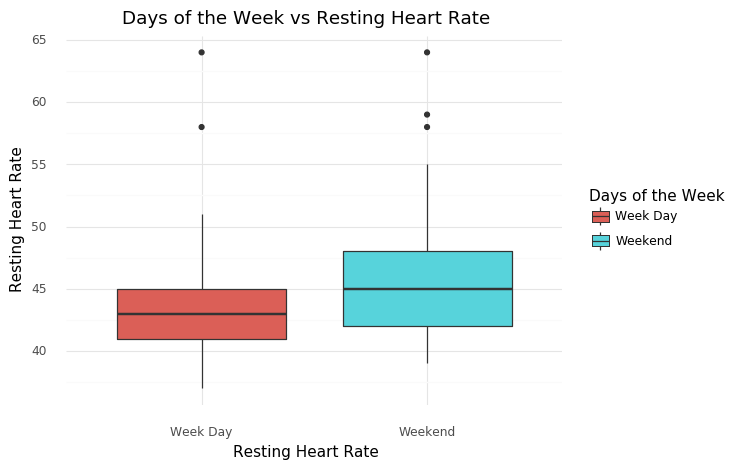

<ggplot: (8743959091569)>

In [143]:
(ggplot(df_combined, aes(x = "Days of the Week", y = "Resting Heart Rate", fill = "Days of the Week")) + 
 ggtitle("Days of the Week vs Resting Heart Rate") + 
 labs(x = "Resting Heart Rate") +
 theme_minimal() +
 
 geom_boxplot())

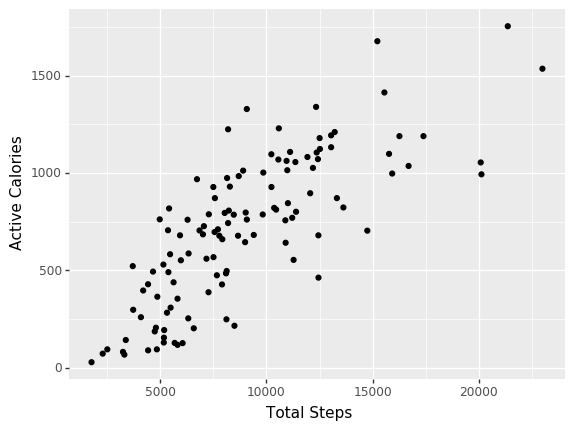

<ggplot: (8743959066277)>

In [144]:
(ggplot(df_combined, aes(x = "Total Steps", y = "Active Calories")) + geom_point())

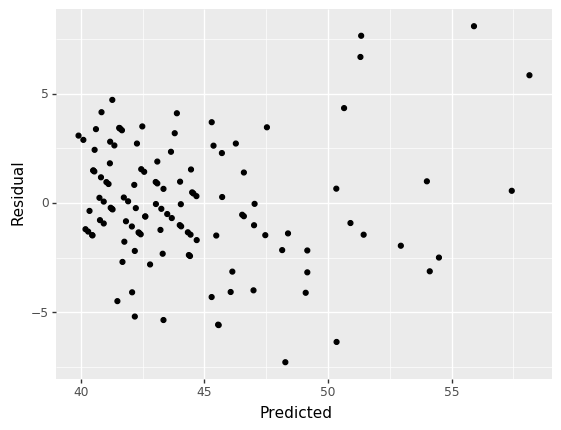

<ggplot: (8743958018277)>

In [155]:
lr = LinearRegression()
# predictors = ["Exercise", "Hrs", "Resting Heart Rate", "Total Steps", "Active Calories"]
predictors = ["Exercise", "Hrs", "Stress Level"]

X = df_combined[predictors]
y = df_combined["Resting Heart Rate"]
lr.fit(X, y)
r2_score(y, lr.predict(X))
y_pred= lr.predict(X)
true_vs_predict = pd.DataFrame({"True" : y, "Predicted" : y_pred, "Residual" : y-y_pred})
(ggplot(true_vs_predict, aes(x = "Predicted", y = "Residual")) + geom_point())

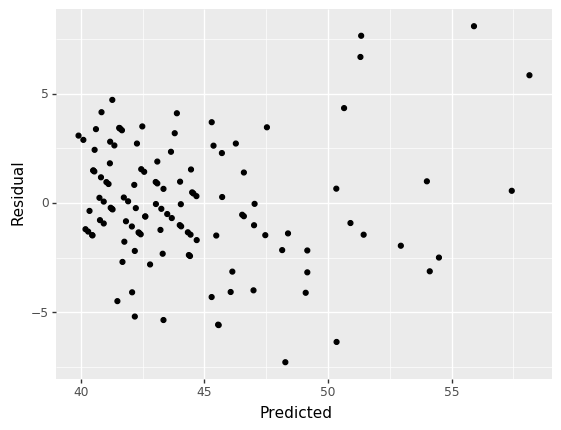

<ggplot: (8743958958537)>

In [156]:
(ggplot(true_vs_predict, aes(x = "Predicted", y = "Residual")) + geom_point())

In [161]:
lg = LogisticRegression()
predictors = ["Stress Level", "Hrs", "Resting Heart Rate"]
X = df_combined[predictors]
y = df_combined["Exercise"]

lg.fit(X, y)

accuracy_score(y, lg.predict(X))

0.7647058823529411

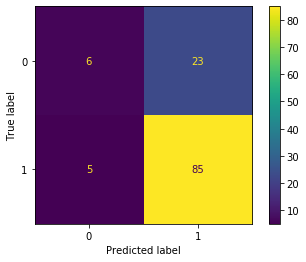

In [158]:
plot_confusion_matrix(lg, X, y)

In [180]:
z = StandardScaler()
hac = AgglomerativeClustering(n_clusters = 2, affinity = "euclidean", linkage = "single")
# features = ["Stress Level", "Hrs", "Resting Heart Rate", "Max Heart Rate", "Active Calories", "Total Steps", "Exercise"]
# features = ["Stress Level", "Hrs", "Resting Heart Rate"]
features = ["Stress Level", "Resting Heart Rate"]


# X_clus = df_combined[features]
# X_clus = z.fit_transform(X_clus)
df_combined[features] = z.fit_transform(df_combined[features])
hac.fit(df_combined[features])

df_combined.head()
dendro = sch.dendrogram(sch.linkage(X_clus, method='complete'))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [177]:
hac_membership = hac.labels_
silhouette_score(X_clus, hac_membership)

0.6709609459522349

In [167]:
X_clus["hac_cluster"] = hac_membership
X_clus.groupby(["hac_cluster"]).mean()
features = ["Stress Level", "Hrs", "Resting Heart Rate"]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [168]:
hac_membership.tolist().count(0)

117

In [ ]:
EM = GaussianMixture(n_components = 2)
EM.fit(X_clus)
em_membership = EM.predict(X_clus)
print("Silhouette score for", 2,"clusters:", silhouette_score(X_clus, em_membership))
silhouette_score(X_clus, em_membership)